In [50]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn,optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions.distribution import Distribution
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [40]:
batch_size=128              
epochs=50        
seed=1         
cuda = False
device = torch.device("cuda" if cuda else "cpu")

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [7]:
def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1)"""
    U = torch.distributions.Uniform(0,1)
    U = U.sample(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(logits.shape)
    m = nn.Softmax(dim=0)
    return m(y/temperature)

### Defining the VAE model here
VAE:
#### Encoder
  (fc1): Linear(in_features=784, out_features=512, bias=True) # fully connected layer 1 <br>
  (fc2): Linear(in_features=512, out_features=256, bias=True) # fully connected layer 2 <br>
  (fc3): Linear(in_features=256, out_features=300, bias=True) # fully connected layer 3 leading to latent space <br>
#### Latent space of dimensions [batch_size * [N*K]] <br>
   The latent variables are parameters of the categorical distribution. We use the gumbel softmax approximation
   to sample from this proxy categorical distribution and backprop.
#### Decoder 
  (fc4): Linear(in_features=300, out_features=256, bias=True)<br>
  (fc5): Linear(in_features=256, out_features=512, bias=True)<br>
  (fc6): Linear(in_features=512, out_features=784, bias=True)<br>

In [25]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.K = 10
        self.N = 30
        self.fc1 = nn.Linear(784,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,self.K*self.N)
        # reshape this into [batch_size*N,K]
        # sample
        # now generative model
        self.fc4 = nn.Linear(self.K*self.N,256)
        self.fc5 = nn.Linear(256,512)
        self.fc6 = nn.Linear(512,784)
        
    def encode(self,x):
        # x is shaped as [128,784] [batch_size, vector of 28x28 pixels]
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = self.fc3(h2) # no activation here
        logits_z = h3.view(-1,self.K) # reshaping 
        m = torch.nn.Softmax(dim=0)
        q_z = m(logits_z)
        
        return logits_z, q_z, torch.log(q_z)
    
    def reparameterize(self,logits,tau):
        z = gumbel_softmax(logits,tau,hard=False).view(-1,N,K)
        
        return z
    
    def reparametrize_categorical(self,logits,tau):
        z = gumbel_softmax_sample(logits,tau)
        z = z.view(-1,self.N,self.K)
        return z
    
    def decode(self,z):
        
        h4 = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(h4))
        logits_x = self.fc6(h5)
        return logits_x
    
    def forward(self,x,tau):
        
        logits_z ,q_z, log_q_z = self.encode(x.view(-1,784)) # q_z is shaped [-1,K] = [N,K], logits shape [-1,K]
        
        z = self.reparametrize_categorical(logits_z,tau) # z is shaped [-1,N,K]
        z_flat = z.view(-1,self.N*self.K)
        logits_x = self.decode(z_flat)
        p_x = torch.distributions.Bernoulli(logits=logits_x)
        p_x = p_x.sample()
        return p_x, q_z, log_q_z

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

tensor([ 0.,  9., 10.])

<bound method Module.state_dict of VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)>

In [59]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1,784), reduction='sum')
    
    KLD = -0.5 * torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    
    return BCE + KLD
    
def train(epoch,tau):
    model.train()
    train_loss = 0
    
    for batch_idx, (data,_) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        print('data is sized',data.shape)
        recon_batch, mu, logvar = model(data,tau) #forward is called here
        loss = loss_function(recon_batch, data, mu, logvar)# calculate loss
        loss.backward() # backprop
        train_loss += loss.item()
        optimizer.step()
        
        if epoch%10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
                
        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 10:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    

if __name__ == "__main__":
    N = 30
    K = 10
    lr = 0.001
    tau0 = 1.0
    temp = tau0
    ANNEAL_RATE = .00003
    MIN_TEMP = 0.5
    dat = []
    train_loss = 0
    for epoch in range(1, epochs + 1):
        if epoch %1 == 0:
            dat.append([epoch,temp,train_loss])
        if epoch %1000 ==1:
            temp = np.maximum(tau0*np.exp(-ANNEAL_RATE*epoch),MIN_TEMP)
        train_loss = train(epoch,temp)
        
        

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 25.4112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 50.7593
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 76.2220
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 101.6635
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 127.0000
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 152.3497
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 177.7746
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 203.2306
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 228.6011
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 254.0055
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 279.4846
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 304.8645
data is sized torch.Size([128, 

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2694.4706
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2719.8888
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2745.2996
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2770.6764
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2796.1431
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2821.5279
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2846.9439
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2872.3046
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2897.6189
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2922.9842
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2948.4689
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 2973.9300
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5236.1173
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5261.5129
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5286.7089
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5312.0012
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5337.3276
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5362.7863
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5388.1733
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5413.5578
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5439.0533
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5464.4684
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5489.8152
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 5515.3115
data is sized to

====> Epoch: 1 Average loss: 7828.4956
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 7854.0031
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 7879.4352
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 7904.7291
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 7930.0766
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 7955.4677
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 7980.9350
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 8006.3211
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 8031.8637
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 8057.3251
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 8082.7180
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 8108.1412
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 A

====> Epoch: 1 Average loss: 10395.9710
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10421.3310
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10446.7783
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10472.1360
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10497.6106
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10523.0160
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10548.4136
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10573.8542
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10599.3477
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10624.8341
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10650.3687
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 1 Average loss: 10675.7139
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1118.5504
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1143.9855
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1169.3372
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1194.6853
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1220.2225
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1245.5741
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1271.0060
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1296.4856
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1321.9604
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1347.2904
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1372.7735
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 1398.1602
data is sized to

====> Epoch: 2 Average loss: 3711.7988
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3737.1133
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3762.4185
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3787.8630
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3813.3410
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3838.7796
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3864.2359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3889.7356
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3915.1793
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3940.5861
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3965.9048
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 3991.2880
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6355.5753
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6380.9571
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6406.4484
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6431.7997
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6457.2205
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6482.5387
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6507.8464
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6533.2598
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6558.7174
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6584.1642
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6609.6359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 6634.9457
data is sized to

====> Epoch: 2 Average loss: 8922.9436
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 8948.3203
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 8973.5945
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 8999.0937
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9024.5515
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9049.8881
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9075.3769
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9100.8591
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9126.2648
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9151.6888
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9177.0377
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 9202.4620
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11590.3458
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11615.7480
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11641.1028
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11666.5703
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11691.9484
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11717.3530
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11742.8502
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11768.2628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11793.7910
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11819.2322
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11844.6603
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 2 Average loss: 11870.0667
data

====> Epoch: 3 Average loss: 2211.1211
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2236.6545
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2262.1749
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2287.6003
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2313.0370
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2338.4699
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2363.9416
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2389.2140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2414.6449
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2440.0768
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2465.4292
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 2490.8508
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 A

====> Epoch: 3 Average loss: 4753.0376
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4778.4894
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4803.8817
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4829.2821
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4854.6882
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4879.9661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4905.3224
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4930.6537
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4956.0383
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 4981.4629
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 5006.9344
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 5032.3968
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 A

====> Epoch: 3 Average loss: 7372.3838
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7397.7732
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7423.2746
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7448.7300
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7474.1614
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7499.6638
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7525.1114
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7550.5219
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7575.9647
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7601.4226
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7626.7938
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 7652.2871
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 A

====> Epoch: 3 Average loss: 9990.1905
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10015.4713
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10041.0073
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10066.4512
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10091.9655
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10117.5074
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10142.8108
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10168.3338
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10193.7413
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10219.2165
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10244.6718
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 3 Average loss: 10270.1318
data is sized torch.Size([128, 1, 28, 28])
====>

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 737.9588
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 763.3839
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 788.7336
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 814.0299
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 839.5035
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 864.8539
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 890.3501
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 915.8768
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 941.3587
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 966.7745
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 991.9468
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 1017.4197
data is sized torch.Size([1

====> Epoch: 4 Average loss: 3280.0332
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3305.3917
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3330.7418
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3356.1681
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3381.6737
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3407.0780
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3432.4146
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3457.6907
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3483.1649
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3508.5342
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3534.0109
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 3559.3396
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 A

====> Epoch: 4 Average loss: 5922.5816
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 5947.9858
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 5973.2768
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 5998.8603
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6024.2556
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6049.5977
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6074.9202
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6100.3628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6125.8062
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6151.2798
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6176.6881
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 6202.1035
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 A

====> Epoch: 4 Average loss: 8465.3432
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8490.9314
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8516.3249
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8541.6751
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8567.1847
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8592.7008
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8618.1970
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8643.6796
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8669.2104
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8694.7177
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8720.0754
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 8745.4746
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 A

====> Epoch: 4 Average loss: 11110.0198
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11135.4730
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11160.8592
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11186.3107
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11211.7690
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11237.2348
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11262.6519
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11288.1344
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11313.4711
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11338.9042
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11364.3345
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 4 Average loss: 11389.6314
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 1855.1379
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 1880.5257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 1905.8439
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 1931.3037
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 1956.6873
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 1982.0752
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 2007.4965
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 2032.9109
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 2058.3932
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 2083.7561
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 2109.2283
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 2134.6490
data is sized to

====> Epoch: 5 Average loss: 4396.7965
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4422.1752
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4447.6734
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4473.1477
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4498.5419
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4523.9236
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4549.3832
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4574.7270
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4600.1242
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4625.6732
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4651.1673
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 4676.5767
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 6963.9702
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 6989.3709
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7014.7019
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7040.0981
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7065.5589
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7090.8034
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7116.2988
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7141.6848
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7167.0378
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7192.4079
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7217.7591
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 7243.1554
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9505.6832
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9531.0314
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9556.4807
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9581.9052
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9607.4082
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9632.8300
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9658.2054
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9683.6839
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9709.1482
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9734.3985
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9759.8156
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 5 Average loss: 9785.1705
data is sized to

====> Epoch: 6 Average loss: 152.6756
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 178.2028
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 203.6935
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 229.0083
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 254.3603
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 279.9283
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 305.3859
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 330.9272
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 356.3863
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 381.7532
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 407.1711
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 432.6315
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss:

====> Epoch: 6 Average loss: 2847.8076
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 2873.1793
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 2898.6568
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 2924.0481
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 2949.4026
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 2974.9496
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 3000.4537
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 3025.8540
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 3051.2541
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 3076.6265
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 3102.0368
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 3127.3944
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5516.7661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5542.2055
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5567.6574
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5593.1001
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5618.6254
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5644.1075
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5669.4560
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5694.8184
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5720.2169
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5745.8368
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5771.2053
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 5796.4855
data is sized to

====> Epoch: 6 Average loss: 8058.3895
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8083.8056
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8109.2160
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8134.7637
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8160.1847
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8185.5518
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8210.9413
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8236.2663
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8261.7288
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8287.0792
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8312.5909
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 8337.8582
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10728.2472
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10753.7582
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10779.1878
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10804.5627
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10830.1311
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10855.5210
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10880.9619
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10906.3421
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10931.8188
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10957.3002
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 10982.7921
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 6 Average loss: 11008.3242
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1474.7390
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1500.1520
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1525.5176
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1550.9764
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1576.3058
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1601.7146
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1627.1592
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1652.6222
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1678.0897
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1703.4545
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1728.9312
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 1754.4228
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4144.0404
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4169.5143
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4195.0473
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4220.4050
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4245.8435
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4271.2138
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4296.6115
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4322.0092
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4347.5863
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4373.0165
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4398.3970
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 4423.8393
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6686.9602
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6712.3293
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6737.8604
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6763.1520
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6788.6706
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6814.0973
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6839.4175
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6864.8639
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6890.2803
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6915.7146
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6941.1653
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 6966.4494
data is sized to

====> Epoch: 7 Average loss: 9330.4292
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9355.8873
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9381.3246
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9406.7799
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9432.1383
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9457.5807
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9482.9795
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9508.4147
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9533.7730
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9559.2009
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9584.4545
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 Average loss: 9609.7910
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 7 A

====> Epoch: 8 Average loss: 25.5054
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 50.9152
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 76.3144
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 101.9560
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 127.3337
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 152.6189
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 178.0918
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 203.6029
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 229.0550
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 254.6491
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 280.0278
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 305.3287
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 33

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2694.9089
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2720.3132
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2745.6470
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2771.1351
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2796.5886
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2821.8610
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2847.2102
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2872.5557
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2898.0021
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2923.4624
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2949.0460
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 2974.5455
data is sized to

====> Epoch: 8 Average loss: 5237.0194
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5262.4843
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5288.0072
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5313.4423
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5338.8893
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5364.3095
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5389.6272
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5415.0767
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5440.5112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5466.0081
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5491.4474
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 5516.7549
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 A

====> Epoch: 8 Average loss: 7778.9762
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7804.4702
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7829.8420
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7855.3338
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7880.7551
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7906.1401
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7931.4029
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7956.9464
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 7982.4232
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 8007.7981
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 8033.3044
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 8058.6503
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10346.6622
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10371.9648
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10397.3586
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10422.8370
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10448.2784
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10473.7257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10499.1600
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10524.5720
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10550.1679
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10575.5709
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10601.0108
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 8 Average loss: 10626.3633
data

====> Epoch: 9 Average loss: 1093.2942
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1118.6643
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1144.0107
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1169.4715
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1194.8733
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1220.3153
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1245.6437
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1271.0166
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1296.3436
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1321.7667
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1347.2607
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 1372.6650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 A

====> Epoch: 9 Average loss: 3761.7516
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3787.2146
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3812.6586
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3838.1952
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3863.5713
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3889.0434
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3914.4952
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3939.7747
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3965.0300
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 3990.3811
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 4015.9587
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 4041.3359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 A

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6431.7965
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6457.1911
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6482.6974
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6508.1117
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6533.4793
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6558.8249
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6584.2661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6609.7365
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6635.1479
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6660.6191
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6686.0088
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 6711.5167
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9100.2687
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9125.5970
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9151.0809
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9176.5429
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9202.0658
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9227.3837
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9252.8972
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9278.1542
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9303.6781
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9329.1843
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9354.6195
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 9380.0840
data is sized to

====> Epoch: 9 Average loss: 11617.0913
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11642.4469
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11667.8401
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11693.3524
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11718.8093
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11744.1881
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11769.6591
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11794.9467
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11820.4081
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11845.7759
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11871.2479
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 9 Average loss: 11896.6097
data is sized torch.Size([96, 1, 28, 28])
====>

Train Epoch: 10 [6912/60000 (12%)]	Loss: 11907.794922
====> Epoch: 10 Average loss: 1398.5438
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7040/60000 (12%)]	Loss: 11969.347656
====> Epoch: 10 Average loss: 1424.0784
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7168/60000 (12%)]	Loss: 11927.842773
====> Epoch: 10 Average loss: 1449.5245
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7296/60000 (12%)]	Loss: 11951.726562
====> Epoch: 10 Average loss: 1475.0215
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7424/60000 (12%)]	Loss: 11863.178711
====> Epoch: 10 Average loss: 1500.3296
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7552/60000 (13%)]	Loss: 11856.372070
====> Epoch: 10 Average loss: 1525.6232
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7680/60000 (13%)]	Loss: 11905.330078
====> Epoch: 10 Average loss: 1551.0212
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [7808/60000 (13%)]	Loss: 

Train Epoch: 10 [14848/60000 (25%)]	Loss: 11864.354492
====> Epoch: 10 Average loss: 2974.9648
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [14976/60000 (25%)]	Loss: 11911.203125
====> Epoch: 10 Average loss: 3000.3754
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [15104/60000 (25%)]	Loss: 11947.626953
====> Epoch: 10 Average loss: 3025.8636
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [15232/60000 (25%)]	Loss: 11925.478516
====> Epoch: 10 Average loss: 3051.3046
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [15360/60000 (26%)]	Loss: 11928.570312
====> Epoch: 10 Average loss: 3076.7523
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [15488/60000 (26%)]	Loss: 11880.397461
====> Epoch: 10 Average loss: 3102.0971
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [15616/60000 (26%)]	Loss: 11954.978516
====> Epoch: 10 Average loss: 3127.6011
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [15744/60000 (26%)

Train Epoch: 10 [22656/60000 (38%)]	Loss: 11922.789062
====> Epoch: 10 Average loss: 4526.1031
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [22784/60000 (38%)]	Loss: 11951.146484
====> Epoch: 10 Average loss: 4551.5989
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [22912/60000 (38%)]	Loss: 11851.575195
====> Epoch: 10 Average loss: 4576.8822
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [23040/60000 (38%)]	Loss: 11912.758789
====> Epoch: 10 Average loss: 4602.2961
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [23168/60000 (39%)]	Loss: 11957.065430
====> Epoch: 10 Average loss: 4627.8045
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [23296/60000 (39%)]	Loss: 11930.725586
====> Epoch: 10 Average loss: 4653.2567
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [23424/60000 (39%)]	Loss: 11883.364258
====> Epoch: 10 Average loss: 4678.6079
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [23552/60000 (39%)

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [30464/60000 (51%)]	Loss: 11932.589844
====> Epoch: 10 Average loss: 6076.9190
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [30592/60000 (51%)]	Loss: 11900.109375
====> Epoch: 10 Average loss: 6102.3058
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [30720/60000 (51%)]	Loss: 11949.837891
====> Epoch: 10 Average loss: 6127.7988
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [30848/60000 (51%)]	Loss: 11899.936523
====> Epoch: 10 Average loss: 6153.1854
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [30976/60000 (52%)]	Loss: 11916.728516
====> Epoch: 10 Average loss: 6178.6077
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [31104/60000 (52%)]	Loss: 11931.189453
====> Epoch: 10 Average loss: 6204.0609
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [31232/60000 (52%)]	Loss: 11854.070312
====> Epoch: 10 Average loss: 6229.3496
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [38528/60000 (64%)]	Loss: 11908.758789
====> Epoch: 10 Average loss: 7678.0798
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [38656/60000 (64%)]	Loss: 11933.884766
====> Epoch: 10 Average loss: 7703.5388
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [38784/60000 (65%)]	Loss: 11988.297852
====> Epoch: 10 Average loss: 7729.1138
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [38912/60000 (65%)]	Loss: 11900.575195
====> Epoch: 10 Average loss: 7754.5017
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [39040/60000 (65%)]	Loss: 11943.634766
====> Epoch: 10 Average loss: 7779.9814
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [39168/60000 (65%)]	Loss: 11956.190430
====> Epoch: 10 Average loss: 7805.4880
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [39296/60000 (65%)]	Loss: 11912.160156
====> Epoch: 10 Average loss: 7830.9006
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [46848/60000 (78%)]	Loss: 11921.360352
====> Epoch: 10 Average loss: 9330.2104
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [46976/60000 (78%)]	Loss: 11873.377930
====> Epoch: 10 Average loss: 9355.5403
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [47104/60000 (78%)]	Loss: 11902.099609
====> Epoch: 10 Average loss: 9380.9315
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [47232/60000 (79%)]	Loss: 11884.379883
====> Epoch: 10 Average loss: 9406.2848
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [47360/60000 (79%)]	Loss: 11910.289062
====> Epoch: 10 Average loss: 9431.6934
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [47488/60000 (79%)]	Loss: 11902.483398
====> Epoch: 10 Average loss: 9457.0854
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [47616/60000 (79%)]	Loss: 11955.534180
====> Epoch: 10 Average loss: 9482.5905
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55040/60000 (92%)]	Loss: 11995.099609
====> Epoch: 10 Average loss: 10957.1295
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55168/60000 (92%)]	Loss: 11981.205078
====> Epoch: 10 Average loss: 10982.6894
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55296/60000 (92%)]	Loss: 11903.654297
====> Epoch: 10 Average loss: 11008.0839
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55424/60000 (92%)]	Loss: 11975.902344
====> Epoch: 10 Average loss: 11033.6324
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55552/60000 (93%)]	Loss: 11909.558594
====> Epoch: 10 Average loss: 11059.0395
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55680/60000 (93%)]	Loss: 11915.589844
====> Epoch: 10 Average loss: 11084.4594
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 10 [55808/60000 (93%)]	Loss: 11949.338867
====> Epoch: 10 Average loss: 11109.9513
data is sized torch.Size([1

====> Epoch: 11 Average loss: 965.6760
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 991.1728
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1016.5840
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1042.0072
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1067.4851
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1092.8790
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1118.2699
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1143.6513
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1169.0377
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1194.4283
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1219.7652
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 1245.1648
data is sized torch.Size([128, 1, 28, 28])
====> 

====> Epoch: 11 Average loss: 3482.3551
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3507.7725
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3533.1175
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3558.5039
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3583.9327
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3609.4650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3634.9453
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3660.3692
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3685.7262
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3711.2536
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3736.6578
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 3762.0346
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6125.1960
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6150.7171
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6176.1661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6201.5563
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6226.9385
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6252.4105
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6277.7930
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6303.3456
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6328.6989
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6354.0235
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6379.5597
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 6405.0265
data

====> Epoch: 11 Average loss: 8642.1044
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8667.4784
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8692.7860
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8718.0862
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8743.5156
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8769.0473
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8794.5344
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8819.9235
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8845.3324
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8870.8349
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8896.2311
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 8921.6854
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11157.4566
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11182.8371
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11208.2736
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11233.7292
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11259.1783
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11284.6561
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11310.1740
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11335.6310
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11361.0076
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11386.3586
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 11411.9750
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 11 Average loss: 114

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1753.5669
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1778.8859
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1804.3155
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1829.7215
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1854.9589
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1880.3532
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1905.7823
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1931.1923
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1956.5789
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 1981.8680
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 2007.1889
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 2032.5773
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4270.2388
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4295.7103
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4321.0426
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4346.4084
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4371.8769
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4397.2495
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4422.5043
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4448.0841
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4473.4824
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4498.9211
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4524.3798
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 4549.7742
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6787.3888
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6812.8020
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6838.1395
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6863.5352
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6888.8955
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6914.1676
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6939.5891
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6964.8964
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 6990.3332
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 7015.7602
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 7041.2046
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 7066.6338
data

====> Epoch: 12 Average loss: 9405.5844
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9431.0052
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9456.5196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9481.9053
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9507.3100
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9532.7330
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9558.0240
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9583.3387
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9608.7034
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9634.1547
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9659.5065
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 12 Average loss: 9684.9460
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 76.3637
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 101.7372
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 127.2169
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 152.6509
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 178.0601
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 203.6848
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 229.2133
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 254.7024
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 280.1138
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 305.6842
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 331.0577
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 356.5144
data is sized tor

====> Epoch: 13 Average loss: 2694.5100
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2719.8069
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2745.2425
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2770.5521
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2796.1506
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2821.5157
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2847.0409
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2872.5235
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2897.9102
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2923.3920
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2948.8309
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 2974.2687
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 13 Average loss: 5211.4614
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5236.7678
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5262.1691
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5287.5083
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5312.9669
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5338.4648
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5363.8451
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5389.1459
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5414.6051
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5440.0838
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5465.5817
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 5490.9388
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 7854.0087
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 7879.5297
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 7904.9681
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 7930.3721
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 7955.7664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 7981.1919
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 8006.5856
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 8031.9257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 8057.4428
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 8082.9099
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 8108.3543
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 8133.6853
data

====> Epoch: 13 Average loss: 10447.7242
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10473.1453
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10498.6181
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10524.0449
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10549.4897
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10574.8985
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10600.4359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10625.9229
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10651.3767
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10676.9369
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10702.3311
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 13 Average loss: 10727.6800
data is sized torch.Size([128, 1, 2

====> Epoch: 14 Average loss: 1143.8593
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1169.2799
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1194.6800
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1220.1044
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1245.4780
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1270.7722
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1296.2196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1321.6387
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1346.9228
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1372.3658
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1397.9368
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 1423.3269
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 14 Average loss: 3787.8006
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3813.2111
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3838.7248
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3864.1811
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3889.6488
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3915.1116
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3940.5503
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3965.9466
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 3991.3118
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 4016.7067
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 4042.0669
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 4067.4653
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6330.2580
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6355.7995
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6381.3210
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6406.7153
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6432.1364
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6457.5875
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6483.0245
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6508.4185
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6533.8057
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6559.3559
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6584.8552
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 6610.1950
data

====> Epoch: 14 Average loss: 8899.0228
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 8924.4053
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 8949.7412
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 8975.2356
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9000.6881
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9026.1856
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9051.5607
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9076.9905
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9102.5186
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9127.9509
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9153.4425
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 9178.8104
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 14 Average loss: 11516.3996
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11541.8416
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11567.2831
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11592.7495
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11618.0380
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11643.4616
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11668.8067
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11694.1850
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11719.6303
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11744.9988
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11770.4007
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 14 Average loss: 11795.8798
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2186.6195
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2212.1966
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2237.6258
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2263.1470
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2288.6321
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2313.9631
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2339.3350
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2364.7739
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2390.1741
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2415.5318
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2441.0360
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 2466.3449
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4728.2583
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4753.7711
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4779.2077
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4804.6204
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4830.0308
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4855.4657
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4880.8678
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4906.3076
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4931.7258
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4957.0713
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 4982.4599
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 5007.8772
data

====> Epoch: 15 Average loss: 7269.9448
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7295.3365
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7320.7630
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7346.2930
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7371.7208
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7397.2877
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7422.6359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7447.8838
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7473.3287
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7498.9069
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7524.2432
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 7549.7530
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 15 Average loss: 9889.1514
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 9914.5268
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 9939.8617
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 9965.3437
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 9990.7015
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10016.1549
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10041.5955
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10067.0423
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10092.4565
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10117.8188
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10143.2246
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 15 Average loss: 10168.5749
data is sized torch.Size([128, 1, 28, 28

====> Epoch: 16 Average loss: 483.0481
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 508.4704
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 533.9572
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 559.2912
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 584.7941
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 610.2270
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 635.6415
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 661.0877
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 686.4091
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 711.8031
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 737.1687
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 762.4857
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 

====> Epoch: 16 Average loss: 3051.7884
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3077.2017
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3102.5807
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3128.0399
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3153.4720
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3178.7811
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3204.1914
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3229.5073
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3254.8319
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3280.3429
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3305.7857
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 3331.2912
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 16 Average loss: 5669.9586
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5695.2850
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5720.7215
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5746.1526
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5771.4927
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5796.8893
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5822.1115
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5847.4828
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5872.8110
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5898.3037
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5923.7677
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 5949.1377
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 16 Average loss: 8210.2330
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8235.6620
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8261.0112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8286.4045
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8311.7738
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8337.3047
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8362.8072
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8388.3125
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8413.6908
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8439.0933
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8464.4515
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 8489.8293
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 16 Average loss: 10752.7930
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10778.1498
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10803.5193
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10828.7735
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10854.2960
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10879.6002
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10905.0714
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10930.5601
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10955.9574
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 10981.2091
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 11006.5871
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 16 Average loss: 11032.0077
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1397.0691
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1422.4088
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1447.7890
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1473.2937
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1498.7563
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1524.1315
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1549.6228
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1574.9881
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1600.3853
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1625.8938
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1651.2355
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 1676.7736
data

====> Epoch: 17 Average loss: 4016.5359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4041.9657
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4067.3630
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4092.7817
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4118.2080
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4143.6470
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4169.0283
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4194.4661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4219.8937
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4245.2700
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4270.6003
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 4296.0440
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6584.0174
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6609.5117
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6634.9196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6660.2257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6685.5773
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6710.9997
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6736.2897
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6761.6589
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6787.2229
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6812.7252
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6838.0618
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 6863.4759
data

====> Epoch: 17 Average loss: 9151.6191
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9177.0032
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9202.5063
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9227.9172
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9253.2837
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9278.7180
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9304.1588
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9329.4714
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9354.7921
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9380.1074
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9405.5710
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 9430.9869
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 11768.3818
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 11793.8390
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 11819.2589
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 11844.8080
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 11870.2352
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 17 Average loss: 11895.7298
data is sized torch.Size([96, 1, 28, 28])
====> Epoch: 17 Average loss: 11914.6850
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 25.4112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 50.8458
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 76.1633
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 101.5858
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 126.9998
data i

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2390.3698
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2415.8579
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2441.3818
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2466.9211
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2492.2624
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2517.7042
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2543.2380
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2568.8074
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2594.2342
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2619.5628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2644.9243
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 2670.4342
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 4984.5893
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5009.9842
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5035.3764
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5060.7644
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5086.1911
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5111.5985
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5137.0064
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5162.5521
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5188.0543
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5213.5120
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5239.0267
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 5264.4303
data

====> Epoch: 18 Average loss: 7525.4872
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7550.9112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7576.1774
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7601.5476
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7627.0200
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7652.5512
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7677.9375
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7703.4113
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7728.9248
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7754.4737
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7779.8498
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 7805.3485
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10068.5772
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10094.0554
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10119.4248
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10144.8371
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10170.2372
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10195.7085
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10221.0102
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10246.4617
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10271.8705
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10297.1544
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 10322.5744
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 18 Average loss: 103

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 712.5238
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 737.9119
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 763.4338
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 788.9278
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 814.2583
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 839.6876
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 865.1005
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 890.4971
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 915.9219
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 941.4117
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 966.7748
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 992.1449
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3330.7942
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3356.1768
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3381.7070
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3407.1547
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3432.5259
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3457.9980
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3483.4566
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3508.8980
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3534.2580
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3559.6996
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3584.9481
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 3610.2097
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 5974.3316
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 5999.8662
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6025.1522
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6050.6001
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6076.0677
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6101.5661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6126.9995
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6152.3196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6177.7418
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6203.1413
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6228.4602
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 6253.8507
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8592.8151
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8618.2748
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8643.6680
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8669.1305
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8694.3854
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8719.7509
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8745.2060
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8770.6689
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8796.1213
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8821.6356
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8847.1397
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 8872.5224
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11109.2752
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11134.7018
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11160.2465
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11185.6435
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11211.0619
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11236.5007
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11261.9898
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11287.4575
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11312.9231
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11338.2532
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 11363.7560
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 19 Average loss: 113

Train Epoch: 20 [5120/60000 (9%)]	Loss: 11933.025391
====> Epoch: 20 Average loss: 1041.9310
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [5248/60000 (9%)]	Loss: 11874.467773
====> Epoch: 20 Average loss: 1067.2632
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [5376/60000 (9%)]	Loss: 11921.645508
====> Epoch: 20 Average loss: 1092.6960
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [5504/60000 (9%)]	Loss: 11901.856445
====> Epoch: 20 Average loss: 1118.0867
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [5632/60000 (9%)]	Loss: 11858.951172
====> Epoch: 20 Average loss: 1143.3858
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [5760/60000 (10%)]	Loss: 11859.339844
====> Epoch: 20 Average loss: 1168.6857
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [5888/60000 (10%)]	Loss: 11904.214844
====> Epoch: 20 Average loss: 1194.0813
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [6016/60000 (10%)]	Loss: 11989

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [13440/60000 (22%)]	Loss: 11922.608398
====> Epoch: 20 Average loss: 2693.9091
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [13568/60000 (23%)]	Loss: 11907.826172
====> Epoch: 20 Average loss: 2719.3124
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [13696/60000 (23%)]	Loss: 11942.234375
====> Epoch: 20 Average loss: 2744.7892
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [13824/60000 (23%)]	Loss: 11908.095703
====> Epoch: 20 Average loss: 2770.1931
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [13952/60000 (23%)]	Loss: 11830.939453
====> Epoch: 20 Average loss: 2795.4325
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [14080/60000 (23%)]	Loss: 11933.867188
====> Epoch: 20 Average loss: 2820.8914
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [14208/60000 (24%)]	Loss: 11970.270508
====> Epoch: 20 Average loss: 2846.4280
data is sized torch.Size([128, 1, 

Train Epoch: 20 [21632/60000 (36%)]	Loss: 11913.599609
====> Epoch: 20 Average loss: 4321.1105
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [21760/60000 (36%)]	Loss: 11918.254883
====> Epoch: 20 Average loss: 4346.5361
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [21888/60000 (36%)]	Loss: 11958.931641
====> Epoch: 20 Average loss: 4372.0485
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [22016/60000 (37%)]	Loss: 11975.326172
====> Epoch: 20 Average loss: 4397.5959
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [22144/60000 (37%)]	Loss: 11917.131836
====> Epoch: 20 Average loss: 4423.0191
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [22272/60000 (37%)]	Loss: 11895.052734
====> Epoch: 20 Average loss: 4448.3952
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [22400/60000 (37%)]	Loss: 11878.515625
====> Epoch: 20 Average loss: 4473.7361
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [22528/60000 (38%)

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [29952/60000 (50%)]	Loss: 11893.092773
====> Epoch: 20 Average loss: 5973.7415
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [30080/60000 (50%)]	Loss: 11908.854492
====> Epoch: 20 Average loss: 5999.1471
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [30208/60000 (50%)]	Loss: 11873.100586
====> Epoch: 20 Average loss: 6024.4764
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [30336/60000 (51%)]	Loss: 11880.729492
====> Epoch: 20 Average loss: 6049.8219
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [30464/60000 (51%)]	Loss: 11891.447266
====> Epoch: 20 Average loss: 6075.1903
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [30592/60000 (51%)]	Loss: 11891.001953
====> Epoch: 20 Average loss: 6100.5578
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [30720/60000 (51%)]	Loss: 11911.187500
====> Epoch: 20 Average loss: 6125.9683
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38016/60000 (63%)]	Loss: 11953.265625
====> Epoch: 20 Average loss: 7575.4532
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38144/60000 (64%)]	Loss: 11904.583008
====> Epoch: 20 Average loss: 7600.8496
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38272/60000 (64%)]	Loss: 11907.359375
====> Epoch: 20 Average loss: 7626.2520
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38400/60000 (64%)]	Loss: 11899.564453
====> Epoch: 20 Average loss: 7651.6377
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38528/60000 (64%)]	Loss: 11842.967773
====> Epoch: 20 Average loss: 7676.9027
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38656/60000 (64%)]	Loss: 11953.175781
====> Epoch: 20 Average loss: 7702.4028
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [38784/60000 (65%)]	Loss: 11944.042969
====> Epoch: 20 Average loss: 7727.8834
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [45696/60000 (76%)]	Loss: 11932.647461
====> Epoch: 20 Average loss: 9100.6305
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [45824/60000 (76%)]	Loss: 11854.724609
====> Epoch: 20 Average loss: 9125.9206
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [45952/60000 (77%)]	Loss: 11876.563477
====> Epoch: 20 Average loss: 9151.2572
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [46080/60000 (77%)]	Loss: 11928.830078
====> Epoch: 20 Average loss: 9176.7054
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [46208/60000 (77%)]	Loss: 11900.843750
====> Epoch: 20 Average loss: 9202.0939
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [46336/60000 (77%)]	Loss: 11891.280273
====> Epoch: 20 Average loss: 9227.4619
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [46464/60000 (77%)]	Loss: 11914.158203
====> Epoch: 20 Average loss: 9252.8788
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [53888/60000 (90%)]	Loss: 11855.124023
====> Epoch: 20 Average loss: 10727.7168
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [54016/60000 (90%)]	Loss: 11945.279297
====> Epoch: 20 Average loss: 10753.2001
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [54144/60000 (90%)]	Loss: 11919.463867
====> Epoch: 20 Average loss: 10778.6282
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [54272/60000 (90%)]	Loss: 11880.765625
====> Epoch: 20 Average loss: 10803.9739
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [54400/60000 (91%)]	Loss: 11914.200195
====> Epoch: 20 Average loss: 10829.3908
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [54528/60000 (91%)]	Loss: 11952.586914
====> Epoch: 20 Average loss: 10854.8897
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 20 [54656/60000 (91%)]	Loss: 11941.025391
====> Epoch: 20 Average loss: 10880.3639
data is sized torch.Size([1

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 610.3230
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 635.7175
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 661.0659
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 686.4955
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 711.8346
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 737.2014
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 762.5815
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 788.0176
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 813.4287
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 838.8002
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 864.2610
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 889.5685
data is sized to

====> Epoch: 21 Average loss: 3203.3414
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3228.6703
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3254.0689
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3279.5098
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3304.9498
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3330.2809
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3355.7485
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3381.2792
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3406.8433
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3432.3456
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3457.8359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 3483.2785
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 21 Average loss: 5798.4231
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5823.9778
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5849.3982
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5874.8007
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5900.2320
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5925.6025
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5951.0476
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 5976.5113
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 6001.9564
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 6027.3105
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 6052.7101
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 6078.2088
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 21 Average loss: 8341.4172
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8366.8166
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8392.3125
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8417.7421
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8443.1655
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8468.6769
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8494.1604
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8519.6622
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8545.0925
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8570.6141
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8595.9611
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 8621.4551
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 10960.1012
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 10985.5039
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11010.8520
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11036.1848
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11061.5672
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11086.9666
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11112.4050
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11137.8100
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11163.1481
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11188.5987
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 11214.0400
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 21 Average loss: 112

====> Epoch: 22 Average loss: 1652.4226
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1677.7217
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1703.1852
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1728.6323
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1754.1682
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1779.5140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1804.8907
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1830.3761
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1855.7888
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1881.1274
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1906.6474
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 1932.0074
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4245.2628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4270.7111
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4296.1028
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4321.4180
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4346.7886
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4372.1896
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4397.6293
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4423.0306
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4448.5728
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4474.0571
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4499.4723
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 4524.9617
data

====> Epoch: 22 Average loss: 6813.5501
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6838.9633
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6864.3997
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6889.8802
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6915.2536
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6940.7051
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6966.1413
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 6991.6116
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 7016.9293
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 7042.3437
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 7067.7852
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 7093.3388
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 22 Average loss: 9457.6966
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9483.1388
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9508.5175
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9533.9796
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9559.4662
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9584.9025
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9610.3714
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9635.8188
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9661.1736
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9686.4833
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9711.9199
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 22 Average loss: 9737.3867
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 127.0664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 152.4941
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 177.8424
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 203.2671
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 228.6846
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 254.1443
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 279.5927
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 305.0406
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 330.5285
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 355.9411
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 381.4507
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 406.8003
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2694.6484
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2720.0640
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2745.5356
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2771.0859
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2796.5558
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2822.0257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2847.5975
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2873.0397
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2898.4329
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2923.7565
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2949.2758
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 2974.6124
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5313.3757
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5338.7874
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5364.1898
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5389.6367
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5415.1655
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5440.5984
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5466.0147
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5491.4468
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5516.8196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5542.1317
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5567.4444
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 5592.8006
data

====> Epoch: 23 Average loss: 7906.2589
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 7931.6924
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 7957.1535
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 7982.5906
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8007.9651
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8033.3475
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8058.7119
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8084.0631
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8109.4801
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8134.9095
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8160.3300
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 8185.7988
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10524.6576
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10550.0380
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10575.4220
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10600.8567
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10626.2858
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10651.7966
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10677.1350
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10702.5327
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10727.9603
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10753.2930
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 10778.7065
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 23 Average loss: 108

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1220.5352
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1246.0065
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1271.2946
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1296.7725
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1322.2619
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1347.6843
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1373.0210
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1398.5363
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1423.8848
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1449.3930
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1474.8239
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 1500.1664
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3837.8543
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3863.2883
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3888.7118
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3914.1640
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3939.6628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3965.0511
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 3990.5427
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 4016.0244
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 4041.3669
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 4066.7542
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 4092.1796
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 4117.5612
data

====> Epoch: 24 Average loss: 6429.9321
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6455.3143
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6480.7389
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6506.1153
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6531.4503
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6556.8370
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6582.3698
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6607.8818
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6633.4792
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6658.8758
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6684.2830
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 6709.7875
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9049.5631
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9075.0038
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9100.5458
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9125.8745
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9151.2371
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9176.7318
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9202.1204
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9227.4863
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9252.9436
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9278.4183
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9303.8840
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 9329.2866
data

====> Epoch: 24 Average loss: 11616.8667
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11642.3594
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11667.7905
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11693.2263
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11718.6742
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11744.0652
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11769.6272
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11795.0414
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11820.4545
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11845.8499
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11871.3472
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 24 Average loss: 11896.7218
data is sized torch.Size([96, 1, 28

====> Epoch: 25 Average loss: 2313.5199
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2339.0087
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2364.5257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2389.9364
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2415.3950
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2440.6286
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2466.0621
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2491.5752
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2516.9721
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2542.4193
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2567.7975
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 2593.2126
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 4855.9136
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 4881.4916
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 4906.8019
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 4932.2138
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 4957.6657
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 4983.0829
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 5008.5310
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 5033.9493
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 5059.2852
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 5084.6812
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 5110.1289
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 5135.5523
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7422.8561
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7448.3094
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7473.6783
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7499.1645
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7524.4963
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7549.9664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7575.5028
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7600.9325
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7626.3690
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7651.6834
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7677.1579
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 7702.5423
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10066.8373
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10092.2777
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10117.8095
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10143.2858
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10168.7521
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10194.2031
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10219.5515
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10244.8824
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10270.3019
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10295.8610
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 10321.2709
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 25 Average loss: 103

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 711.8942
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 737.3069
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 762.7023
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 788.1033
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 813.4250
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 838.8977
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 864.4057
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 889.6952
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 915.1752
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 940.4942
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 965.8835
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 991.3696
data is sized to

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3227.7851
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3253.1682
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3278.5976
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3304.0103
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3329.4136
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3354.7523
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3380.1066
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3405.3726
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3430.7722
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3456.0831
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3481.4747
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 3506.9489
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5795.4305
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5821.0223
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5846.4602
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5871.8224
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5897.2043
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5922.6837
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5948.1363
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5973.6047
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 5999.0647
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 6024.5217
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 6049.9769
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 6075.3243
data

====> Epoch: 26 Average loss: 8414.4664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8439.8551
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8465.1157
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8490.6093
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8516.0510
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8541.3777
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8566.8586
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8592.3558
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8617.8460
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8643.2361
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8668.6514
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 8693.9614
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 26 Average loss: 11007.5621
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11032.9473
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11058.3029
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11083.7020
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11109.1716
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11134.6650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11160.1160
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11185.4993
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11210.9138
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11236.5077
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11261.8475
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 26 Average loss: 11287.2479
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1703.4576
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1728.8134
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1754.2305
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1779.6807
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1805.1415
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1830.4551
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1855.8649
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1881.1011
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1906.4394
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1931.8676
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1957.3306
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 1982.7950
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4244.4395
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4269.7958
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4295.2287
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4320.7819
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4346.3140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4371.8174
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4397.2823
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4422.6394
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4448.1435
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4473.5478
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4498.9628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 4524.4114
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6837.2637
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6862.6523
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6888.1357
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6913.5975
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6938.9569
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6964.4964
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 6989.8878
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 7015.3055
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 7040.8319
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 7066.2691
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 7091.6069
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 7116.9949
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9429.8439
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9455.3085
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9480.7385
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9506.1211
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9531.5735
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9557.0387
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9582.4032
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9607.8070
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9633.2939
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9658.7664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9684.1858
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 27 Average loss: 9709.6963
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 76.2556
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 101.6720
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 127.1431
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 152.6355
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 178.0418
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 203.3928
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 228.7721
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 254.2247
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 279.7176
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 305.1875
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 330.6322
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 356.1910
data is sized tor

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2644.7145
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2670.0396
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2695.3427
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2720.7017
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2746.1897
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2771.6313
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2797.0834
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2822.5487
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2848.0166
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2873.4052
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2898.7734
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 2924.1684
data

====> Epoch: 28 Average loss: 5237.4541
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5262.8330
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5288.4218
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5313.9605
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5339.5420
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5364.8852
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5390.3369
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5415.6560
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5441.0466
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5466.5231
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5492.0021
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 5517.5227
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 28 Average loss: 7831.3598
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 7856.6468
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 7882.1236
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 7907.5432
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 7932.8432
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 7958.4465
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 7983.9193
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 8009.3118
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 8034.7790
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 8060.3162
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 8085.7767
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 8111.1636
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10474.3580
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10499.7715
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10525.2082
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10550.5868
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10575.9011
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10601.2739
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10626.7034
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10652.1655
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10677.5525
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10702.9684
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 10728.4002
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 28 Average loss: 107

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1144.8503
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1170.2308
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1195.5758
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1220.9650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1246.3498
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1271.6320
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1297.1518
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1322.6565
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1348.0010
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1373.4651
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1398.8833
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 1424.2448
data

====> Epoch: 29 Average loss: 3737.2806
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3762.7252
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3787.9970
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3813.4778
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3838.9561
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3864.5361
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3889.8408
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3915.1695
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3940.6660
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3966.1339
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 3991.6146
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 4017.1108
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 29 Average loss: 6329.8618
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6355.3076
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6380.7165
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6406.0183
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6431.5053
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6456.9697
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6482.4920
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6507.9514
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6533.3433
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6558.8042
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6584.3399
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 6609.8140
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 29 Average loss: 8950.0326
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 8975.4184
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9000.7747
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9026.2298
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9051.6326
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9077.2070
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9102.6739
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9128.0409
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9153.4653
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9178.9385
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9204.3154
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 9229.7533
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 29 Average loss: 11543.2554
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11568.5324
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11594.0408
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11619.3540
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11644.8063
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11670.1809
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11695.5086
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11720.8831
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11746.2807
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11771.6756
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11797.0994
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 29 Average loss: 11822.5795
data is sized torch.Size([128, 1, 2

Train Epoch: 30 [6912/60000 (12%)]	Loss: 11912.478516
====> Epoch: 30 Average loss: 1397.8708
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7040/60000 (12%)]	Loss: 11913.297852
====> Epoch: 30 Average loss: 1423.2858
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7168/60000 (12%)]	Loss: 11978.235352
====> Epoch: 30 Average loss: 1448.8394
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7296/60000 (12%)]	Loss: 11910.805664
====> Epoch: 30 Average loss: 1474.2491
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7424/60000 (12%)]	Loss: 11835.670898
====> Epoch: 30 Average loss: 1499.4985
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7552/60000 (13%)]	Loss: 11949.547852
====> Epoch: 30 Average loss: 1524.9909
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7680/60000 (13%)]	Loss: 11943.500977
====> Epoch: 30 Average loss: 1550.4704
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [7808/60000 (13%)]	Loss: 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15104/60000 (25%)]	Loss: 11905.967773
====> Epoch: 30 Average loss: 3025.0457
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15232/60000 (25%)]	Loss: 11921.791992
====> Epoch: 30 Average loss: 3050.4789
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15360/60000 (26%)]	Loss: 11946.558594
====> Epoch: 30 Average loss: 3075.9649
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15488/60000 (26%)]	Loss: 11889.292969
====> Epoch: 30 Average loss: 3101.3287
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15616/60000 (26%)]	Loss: 11917.065430
====> Epoch: 30 Average loss: 3126.7518
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15744/60000 (26%)]	Loss: 11955.385742
====> Epoch: 30 Average loss: 3152.2566
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [15872/60000 (26%)]	Loss: 11882.633789
====> Epoch: 30 Average loss: 3177.6062
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [23296/60000 (39%)]	Loss: 11904.266602
====> Epoch: 30 Average loss: 4651.7114
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [23424/60000 (39%)]	Loss: 11887.247070
====> Epoch: 30 Average loss: 4677.0709
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [23552/60000 (39%)]	Loss: 11941.602539
====> Epoch: 30 Average loss: 4702.5463
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [23680/60000 (39%)]	Loss: 11954.760742
====> Epoch: 30 Average loss: 4728.0498
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [23808/60000 (40%)]	Loss: 11940.414062
====> Epoch: 30 Average loss: 4753.5227
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [23936/60000 (40%)]	Loss: 11910.995117
====> Epoch: 30 Average loss: 4778.9328
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [24064/60000 (40%)]	Loss: 11883.666016
====> Epoch: 30 Average loss: 4804.2846
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [31616/60000 (53%)]	Loss: 11965.876953
====> Epoch: 30 Average loss: 6305.0558
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [31744/60000 (53%)]	Loss: 11898.874023
====> Epoch: 30 Average loss: 6330.4401
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [31872/60000 (53%)]	Loss: 11926.736328
====> Epoch: 30 Average loss: 6355.8838
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [32000/60000 (53%)]	Loss: 11919.226562
====> Epoch: 30 Average loss: 6381.3115
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [32128/60000 (54%)]	Loss: 11897.221680
====> Epoch: 30 Average loss: 6406.6922
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [32256/60000 (54%)]	Loss: 11925.004883
====> Epoch: 30 Average loss: 6432.1322
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [32384/60000 (54%)]	Loss: 11941.446289
====> Epoch: 30 Average loss: 6457.6073
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [39680/60000 (66%)]	Loss: 11892.523438
====> Epoch: 30 Average loss: 7905.5347
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [39808/60000 (66%)]	Loss: 11820.582031
====> Epoch: 30 Average loss: 7930.7519
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [39936/60000 (67%)]	Loss: 11966.124023
====> Epoch: 30 Average loss: 7956.2796
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [40064/60000 (67%)]	Loss: 11922.919922
====> Epoch: 30 Average loss: 7981.7152
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [40192/60000 (67%)]	Loss: 11896.878906
====> Epoch: 30 Average loss: 8007.0952
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [40320/60000 (67%)]	Loss: 11992.498047
====> Epoch: 30 Average loss: 8032.6792
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [40448/60000 (67%)]	Loss: 11950.009766
====> Epoch: 30 Average loss: 8058.1726
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [47360/60000 (79%)]	Loss: 11918.361328
====> Epoch: 30 Average loss: 9431.3428
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [47488/60000 (79%)]	Loss: 11864.894531
====> Epoch: 30 Average loss: 9456.6546
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [47616/60000 (79%)]	Loss: 11954.374023
====> Epoch: 30 Average loss: 9482.1572
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [47744/60000 (80%)]	Loss: 11930.881836
====> Epoch: 30 Average loss: 9507.6098
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [47872/60000 (80%)]	Loss: 11901.779297
====> Epoch: 30 Average loss: 9533.0002
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [48000/60000 (80%)]	Loss: 11850.457031
====> Epoch: 30 Average loss: 9558.2812
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [48128/60000 (80%)]	Loss: 11894.062500
====> Epoch: 30 Average loss: 9583.6552
data is sized torch.Size([128, 1, 

Train Epoch: 30 [55552/60000 (93%)]	Loss: 11921.014648
====> Epoch: 30 Average loss: 11057.9760
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [55680/60000 (93%)]	Loss: 11961.042969
====> Epoch: 30 Average loss: 11083.4929
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [55808/60000 (93%)]	Loss: 11925.355469
====> Epoch: 30 Average loss: 11108.9337
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [55936/60000 (93%)]	Loss: 11952.813477
====> Epoch: 30 Average loss: 11134.4330
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [56064/60000 (93%)]	Loss: 11883.593750
====> Epoch: 30 Average loss: 11159.7847
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [56192/60000 (94%)]	Loss: 11905.372070
====> Epoch: 30 Average loss: 11185.1828
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [56320/60000 (94%)]	Loss: 11890.311523
====> Epoch: 30 Average loss: 11210.5488
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 30 [56448/6000

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1144.1545
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1169.6749
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1195.0494
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1220.4219
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1245.8716
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1271.2291
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1296.7594
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1322.2088
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1347.4740
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1372.9027
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1398.4105
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 1423.8156
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3738.0071
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3763.3223
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3788.7402
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3814.0312
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3839.4044
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3864.8369
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3890.1056
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3915.5727
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3940.9650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3966.2949
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 3991.8354
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 4017.2418
data

====> Epoch: 31 Average loss: 6329.6700
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6355.1942
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6380.6415
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6406.0590
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6431.4824
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6456.9631
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6482.4196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6507.9442
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6533.3390
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6558.7367
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6584.2075
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 6609.7006
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 8870.7674
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 8896.2382
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 8921.4516
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 8946.8798
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 8972.3817
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 8997.7267
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 9023.2087
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 9048.5603
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 9074.0242
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 9099.4442
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 9124.9254
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 9150.3348
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11388.2968
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11413.6335
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11438.9958
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11464.3044
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11489.8343
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11515.1054
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11540.6113
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11566.0463
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11591.4917
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11616.9626
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 11642.4212
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 31 Average loss: 116

====> Epoch: 32 Average loss: 2007.7918
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2033.1980
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2058.5859
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2084.1356
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2109.5014
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2134.9681
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2160.4278
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2185.9559
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2211.3530
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2236.8381
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2262.2089
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 2287.5652
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 32 Average loss: 4627.2901
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4652.6408
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4677.9860
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4703.2896
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4728.8020
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4754.1016
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4779.5414
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4804.9531
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4830.2745
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4855.6712
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4881.1118
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 4906.4518
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7244.8105
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7270.2171
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7295.6498
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7321.0647
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7346.4638
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7371.9678
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7397.3989
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7422.9167
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7448.5449
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7473.9971
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7499.3615
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 7524.8056
data

====> Epoch: 32 Average loss: 9837.5900
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 9863.0519
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 9888.4968
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 9913.8482
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 9939.3618
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 9964.7856
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 9990.2201
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 10015.6316
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 10041.0449
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 10066.5028
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 10091.9948
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 32 Average loss: 10117.4704
data is sized torch.Size([128, 1, 28, 28])

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 508.5886
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 534.0329
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 559.3640
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 584.7919
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 610.2266
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 635.9020
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 661.4802
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 686.9656
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 712.4767
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 737.8095
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 763.3348
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 788.5939
data is sized to

====> Epoch: 33 Average loss: 3075.5665
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3101.0403
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3126.4453
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3151.8951
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3177.3034
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3202.7755
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3228.1653
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3253.5948
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3278.7801
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3304.1049
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3329.4811
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 3354.9815
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5693.6053
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5719.0684
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5744.4781
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5769.8471
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5795.3148
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5820.8393
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5846.1725
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5871.7064
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5897.0151
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5922.3574
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5947.8509
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 5973.0825
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8261.6676
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8287.1644
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8312.7419
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8338.1312
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8363.5955
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8389.0377
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8414.4264
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8439.8360
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8465.3571
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8490.7599
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8516.1073
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 8541.5163
data

====> Epoch: 33 Average loss: 10880.6394
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 10906.0037
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 10931.5115
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 10956.8450
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 10982.2738
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11007.6390
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11033.1175
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11058.5336
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11083.9645
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11109.4587
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11134.8774
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 33 Average loss: 11160.1603
data is sized torch.Size([128, 1, 2

====> Epoch: 34 Average loss: 1575.9103
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1601.2873
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1626.7566
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1652.1654
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1677.4502
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1702.8861
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1728.2480
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1753.6230
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1779.0684
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1804.5676
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1830.0576
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 1855.3912
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 34 Average loss: 4194.8324
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4220.2862
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4245.6604
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4270.9776
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4296.4215
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4321.8132
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4347.1960
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4372.6293
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4398.1262
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4423.5381
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4448.9773
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 4474.2711
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6810.7894
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6836.1622
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6861.6872
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6887.0372
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6912.6120
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6937.9649
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6963.3172
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 6988.7557
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 7014.1846
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 7039.6235
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 7064.8936
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 7090.2128
data

====> Epoch: 34 Average loss: 9429.0997
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9454.5074
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9479.9332
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9505.4740
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9530.9367
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9556.4010
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9581.8820
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9607.2742
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9632.6569
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9657.9583
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9683.5243
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 34 Average loss: 9708.9347
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 35 Average loss: 101.7308
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 127.1833
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 152.8043
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 178.1804
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 203.5195
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 228.9345
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 254.3561
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 279.7513
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 305.1091
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 330.5140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 356.0091
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 381.4378
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2770.5272
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2795.9912
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2821.4241
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2846.8443
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2872.1834
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2897.5495
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2922.9973
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2948.3806
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2973.8749
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 2999.1460
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 3024.5678
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 3050.0101
data

====> Epoch: 35 Average loss: 5389.8770
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5415.2529
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5440.6180
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5465.9683
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5491.3412
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5516.8743
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5542.2504
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5567.6462
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5593.0187
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5618.4730
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5643.8910
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 5669.3423
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8034.1536
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8059.6365
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8085.0588
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8110.5885
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8136.0126
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8161.3843
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8186.8714
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8212.2750
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8237.6420
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8263.0642
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8288.4496
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 8313.8500
data

====> Epoch: 35 Average loss: 10550.7591
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10576.2921
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10601.7401
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10627.1679
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10652.7190
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10678.1432
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10703.6012
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10728.9784
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10754.3061
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10779.7475
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10805.2435
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 35 Average loss: 10830.6405
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1220.2180
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1245.6594
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1271.2117
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1296.7380
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1322.3325
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1347.6681
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1373.0286
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1398.4790
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1423.9580
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1449.2972
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1474.7838
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 1500.2307
data

====> Epoch: 36 Average loss: 3813.1498
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3838.7664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3864.3730
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3889.7494
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3915.0281
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3940.5207
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3965.9308
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 3991.3452
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 4016.7840
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 4042.3750
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 4067.9126
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 4093.3469
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 36 Average loss: 6431.6346
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6457.1405
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6482.5365
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6507.9934
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6533.4864
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6558.8699
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6584.2231
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6609.4994
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6634.9356
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6660.3112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6685.8278
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 6711.2385
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9051.7263
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9077.1776
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9102.5925
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9127.9937
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9153.5900
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9179.0315
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9204.4614
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9229.7852
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9255.1799
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9280.4256
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9305.9012
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 9331.2441
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11543.2468
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11568.7402
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11594.1459
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11619.5066
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11644.9016
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11670.3230
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11695.6967
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11721.0643
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11746.5451
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11771.9826
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 11797.3738
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 36 Average loss: 118

====> Epoch: 37 Average loss: 2237.7878
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2263.1415
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2288.5974
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2314.0840
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2339.4880
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2364.8785
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2390.2876
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2415.7515
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2441.1658
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2466.6175
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2491.9999
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 2517.4690
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 37 Average loss: 4856.7271
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 4882.0758
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 4907.3783
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 4932.7037
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 4958.1662
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 4983.5966
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 5008.9065
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 5034.4047
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 5059.7127
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 5085.0603
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 5110.5710
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 5135.9504
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 37 Average loss: 7423.9389
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7449.3328
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7474.7146
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7500.1462
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7525.4962
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7550.9533
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7576.3725
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7601.8412
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7627.2027
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7652.4280
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7677.8139
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 7703.1558
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 37 Average loss: 9990.9448
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10016.3349
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10041.7085
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10067.0888
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10092.3664
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10117.8849
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10143.1940
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10168.6910
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10194.1150
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10219.4853
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10244.8448
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 37 Average loss: 10270.1893
data is sized torch.Size([128, 1, 28

====> Epoch: 38 Average loss: 660.7503
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 686.2118
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 711.5909
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 737.0795
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 762.4063
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 787.8170
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 813.2202
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 838.5011
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 863.9597
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 889.3940
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 914.7752
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 940.1721
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3253.3383
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3278.7867
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3304.1926
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3329.7679
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3355.1517
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3380.6561
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3406.0519
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3431.4833
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3456.9431
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3482.4942
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3507.8052
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 3533.3468
data

====> Epoch: 38 Average loss: 5872.0009
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 5897.3355
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 5922.8241
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 5948.2742
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 5973.6825
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 5999.0539
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 6024.4068
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 6049.7013
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 6075.0600
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 6100.3855
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 6125.6719
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 6151.0811
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 38 Average loss: 8463.9187
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8489.2731
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8514.6609
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8540.0203
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8565.4690
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8590.9005
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8616.3496
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8641.8084
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8667.1921
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8692.6586
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8718.0114
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 8743.4127
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 38 Average loss: 11030.9322
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11056.3630
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11081.6496
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11107.0401
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11132.4129
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11157.8411
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11183.3119
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11208.6184
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11234.0883
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11259.4833
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11284.9840
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 38 Average loss: 11310.3847
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1727.4706
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1752.9697
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1778.4064
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1803.8532
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1829.2444
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1854.6934
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1880.0444
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1905.4751
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1930.8375
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1956.3013
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 1981.6332
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 2007.1323
data

====> Epoch: 39 Average loss: 4294.5217
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4319.8686
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4345.2427
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4370.6186
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4396.1321
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4421.4443
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4446.8845
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4472.3077
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4497.7297
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4523.0694
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4548.3792
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 4573.7408
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 39 Average loss: 6810.4443
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6835.8821
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6861.2057
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6886.6998
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6912.1093
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6937.4901
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6962.8360
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 6988.3048
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 7013.7583
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 7039.1965
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 7064.5742
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 7090.0743
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9403.1355
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9428.6186
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9454.1180
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9479.4977
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9504.8070
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9530.2461
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9555.6839
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9581.1159
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9606.6197
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9632.0850
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9657.4322
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 39 Average loss: 9682.8585
data

Train Epoch: 40 [128/60000 (0%)]	Loss: 11912.651367
====> Epoch: 40 Average loss: 50.7504
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [256/60000 (0%)]	Loss: 11921.057617
====> Epoch: 40 Average loss: 76.1820
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [384/60000 (1%)]	Loss: 11887.591797
====> Epoch: 40 Average loss: 101.5422
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [512/60000 (1%)]	Loss: 11916.787109
====> Epoch: 40 Average loss: 126.9647
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [640/60000 (1%)]	Loss: 11902.827148
====> Epoch: 40 Average loss: 152.3574
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [768/60000 (1%)]	Loss: 11959.916992
====> Epoch: 40 Average loss: 177.8719
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [896/60000 (1%)]	Loss: 11894.039062
====> Epoch: 40 Average loss: 203.2458
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [1024/60000 (2%)]	Loss: 11909.543945
====> Epoch

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [8320/60000 (14%)]	Loss: 11910.549805
====> Epoch: 40 Average loss: 1677.8375
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [8448/60000 (14%)]	Loss: 11923.190430
====> Epoch: 40 Average loss: 1703.2736
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [8576/60000 (14%)]	Loss: 11934.208008
====> Epoch: 40 Average loss: 1728.7332
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [8704/60000 (14%)]	Loss: 11933.041016
====> Epoch: 40 Average loss: 1754.1904
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [8832/60000 (15%)]	Loss: 11892.356445
====> Epoch: 40 Average loss: 1779.5608
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [8960/60000 (15%)]	Loss: 11969.126953
====> Epoch: 40 Average loss: 1805.0949
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [9088/60000 (15%)]	Loss: 11894.848633
====> Epoch: 40 Average loss: 1830.4706
data is sized torch.Size([128, 1, 28, 28]

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [16512/60000 (28%)]	Loss: 11896.582031
====> Epoch: 40 Average loss: 3305.5918
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [16640/60000 (28%)]	Loss: 11934.041016
====> Epoch: 40 Average loss: 3331.0511
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [16768/60000 (28%)]	Loss: 11922.028320
====> Epoch: 40 Average loss: 3356.4848
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [16896/60000 (28%)]	Loss: 11912.819336
====> Epoch: 40 Average loss: 3381.8988
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [17024/60000 (28%)]	Loss: 11904.128906
====> Epoch: 40 Average loss: 3407.2942
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [17152/60000 (29%)]	Loss: 11985.562500
====> Epoch: 40 Average loss: 3432.8634
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [17280/60000 (29%)]	Loss: 11947.304688
====> Epoch: 40 Average loss: 3458.3510
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [24704/60000 (41%)]	Loss: 11874.005859
====> Epoch: 40 Average loss: 4931.5489
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [24832/60000 (41%)]	Loss: 11881.629883
====> Epoch: 40 Average loss: 4956.8963
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [24960/60000 (42%)]	Loss: 11960.237305
====> Epoch: 40 Average loss: 4982.4115
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [25088/60000 (42%)]	Loss: 11874.015625
====> Epoch: 40 Average loss: 5007.7428
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [25216/60000 (42%)]	Loss: 11933.693359
====> Epoch: 40 Average loss: 5033.2013
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [25344/60000 (42%)]	Loss: 11902.099609
====> Epoch: 40 Average loss: 5058.5924
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [25472/60000 (42%)]	Loss: 11951.940430
====> Epoch: 40 Average loss: 5084.0899
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [32896/60000 (55%)]	Loss: 11864.300781
====> Epoch: 40 Average loss: 6558.1448
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [33024/60000 (55%)]	Loss: 11916.855469
====> Epoch: 40 Average loss: 6583.5674
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [33152/60000 (55%)]	Loss: 11853.350586
====> Epoch: 40 Average loss: 6608.8546
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [33280/60000 (55%)]	Loss: 11874.594727
====> Epoch: 40 Average loss: 6634.1871
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [33408/60000 (56%)]	Loss: 11935.024414
====> Epoch: 40 Average loss: 6659.6484
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [33536/60000 (56%)]	Loss: 11948.754883
====> Epoch: 40 Average loss: 6685.1391
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [33664/60000 (56%)]	Loss: 11903.304688
====> Epoch: 40 Average loss: 6710.5328
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41088/60000 (68%)]	Loss: 11894.256836
====> Epoch: 40 Average loss: 8184.8993
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41216/60000 (69%)]	Loss: 11964.916016
====> Epoch: 40 Average loss: 8210.4245
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41344/60000 (69%)]	Loss: 11908.121094
====> Epoch: 40 Average loss: 8235.8285
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41472/60000 (69%)]	Loss: 11909.582031
====> Epoch: 40 Average loss: 8261.2356
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41600/60000 (69%)]	Loss: 11881.901367
====> Epoch: 40 Average loss: 8286.5836
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41728/60000 (70%)]	Loss: 11920.104492
====> Epoch: 40 Average loss: 8312.0132
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [41856/60000 (70%)]	Loss: 11883.158203
====> Epoch: 40 Average loss: 8337.3639
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [49280/60000 (82%)]	Loss: 11883.762695
====> Epoch: 40 Average loss: 9811.6118
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [49408/60000 (82%)]	Loss: 11881.290039
====> Epoch: 40 Average loss: 9836.9586
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [49536/60000 (83%)]	Loss: 11901.973633
====> Epoch: 40 Average loss: 9862.3494
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [49664/60000 (83%)]	Loss: 11937.909180
====> Epoch: 40 Average loss: 9887.8170
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [49792/60000 (83%)]	Loss: 11918.603516
====> Epoch: 40 Average loss: 9913.2433
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [49920/60000 (83%)]	Loss: 11900.033203
====> Epoch: 40 Average loss: 9938.6301
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [50048/60000 (83%)]	Loss: 11887.138672
====> Epoch: 40 Average loss: 9963.9893
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [57344/60000 (96%)]	Loss: 11982.999023
====> Epoch: 40 Average loss: 11412.8789
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [57472/60000 (96%)]	Loss: 11902.833984
====> Epoch: 40 Average loss: 11438.2716
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [57600/60000 (96%)]	Loss: 11897.500000
====> Epoch: 40 Average loss: 11463.6530
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [57728/60000 (96%)]	Loss: 11952.494141
====> Epoch: 40 Average loss: 11489.1516
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [57856/60000 (96%)]	Loss: 11899.936523
====> Epoch: 40 Average loss: 11514.5382
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [57984/60000 (97%)]	Loss: 11926.979492
====> Epoch: 40 Average loss: 11539.9824
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 40 [58112/60000 (97%)]	Loss: 11926.804688
====> Epoch: 40 Average loss: 11565.4262
data is sized torch.Size([1

====> Epoch: 41 Average loss: 1652.3837
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1677.9341
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1703.3844
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1728.7303
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1754.2421
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1779.5729
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1804.9943
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1830.3257
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1855.6845
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1881.0359
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1906.5034
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 1931.9006
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 41 Average loss: 4296.8314
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4322.2403
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4347.6439
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4373.0115
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4398.4482
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4423.9329
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4449.2780
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4474.7508
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4500.1587
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4525.5529
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4551.0419
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 4576.4920
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 6890.4538
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 6916.1174
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 6941.5043
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 6966.9772
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 6992.3760
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7017.7533
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7043.1853
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7068.6809
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7094.1499
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7119.5726
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7145.0229
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 7170.4042
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9483.6996
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9509.0944
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9534.4980
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9559.8303
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9585.2739
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9610.6610
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9636.0712
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9661.5193
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9686.9153
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9712.4413
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9737.8455
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 41 Average loss: 9763.3444
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 178.1487
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 203.6131
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 229.0297
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 254.4244
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 279.8406
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 305.3222
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 330.7321
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 356.0977
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 381.4744
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 406.8945
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 432.2567
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 457.5736
data is sized to

====> Epoch: 42 Average loss: 2720.6110
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2745.9835
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2771.3837
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2796.8366
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2822.1250
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2847.6240
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2873.0640
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2898.4595
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2923.8739
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2949.2784
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 2974.6685
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 3000.0702
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5338.6302
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5364.0515
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5389.4533
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5414.8977
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5440.2869
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5465.6717
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5490.9661
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5516.4916
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5541.9031
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5567.3981
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5592.8010
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 5618.1394
data

====> Epoch: 42 Average loss: 7930.6963
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 7956.1600
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 7981.6295
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8007.0480
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8032.3940
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8057.7060
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8083.0740
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8108.5295
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8133.9565
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8159.4474
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8184.8388
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 8210.2452
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10522.4929
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10547.8697
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10573.2927
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10598.6172
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10624.0116
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10649.4494
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10674.8459
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10700.2605
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10725.6488
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10750.8128
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 10776.1870
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 42 Average loss: 108

====> Epoch: 43 Average loss: 1144.0820
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1169.5069
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1194.7876
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1220.2133
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1245.6720
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1271.1802
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1296.6383
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1322.0844
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1347.4666
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1372.8852
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1398.4181
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 1423.7797
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 43 Average loss: 3711.0141
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3736.4126
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3761.8054
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3787.2385
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3812.5851
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3838.0198
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3863.4512
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3888.9196
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3914.3306
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3939.7270
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3965.2577
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 3990.6345
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 43 Average loss: 6329.4318
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6354.8838
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6380.3062
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6405.5834
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6431.0191
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6456.4736
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6481.7938
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6507.1505
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6532.6101
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6558.1371
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6583.5425
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 6608.9939
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 43 Average loss: 8948.0792
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 8973.5795
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 8999.0137
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9024.4533
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9049.8963
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9075.2761
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9100.6781
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9126.1243
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9151.6454
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9177.0556
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9202.5011
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 9227.8749
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11516.0919
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11541.4912
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11566.9126
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11592.3140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11617.8431
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11643.2699
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11668.6999
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11694.1869
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11719.6437
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11745.0320
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 11770.4650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 43 Average loss: 117

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2212.0628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2237.4399
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2262.8319
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2288.0953
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2313.5580
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2338.9486
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2364.2884
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2389.6850
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2415.0929
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2440.5242
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2465.9463
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 2491.3475
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4753.2462
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4778.5687
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4803.8513
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4829.4087
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4854.8030
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4880.2538
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4905.6642
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4931.0135
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4956.4792
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 4981.8267
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 5007.2406
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 5032.7934
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7371.3769
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7396.7229
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7422.2157
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7447.6322
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7473.0084
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7498.4549
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7523.8183
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7549.2487
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7574.7000
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7600.0921
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7625.5668
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 7650.9283
data

====> Epoch: 44 Average loss: 9937.7584
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 9963.2646
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 9988.7715
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10014.1422
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10039.5328
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10064.9062
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10090.3366
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10115.8080
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10141.3213
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10166.7398
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10192.1931
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 44 Average loss: 10217.6581
data is sized torch.Size([128, 1, 28, 

====> Epoch: 45 Average loss: 584.6086
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 610.1098
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 635.6274
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 661.1080
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 686.5883
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 712.0277
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 737.5172
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 762.8277
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 788.3187
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 813.7219
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 839.1120
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 864.6090
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 

====> Epoch: 45 Average loss: 3128.0342
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3153.3129
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3178.7152
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3204.2030
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3229.7230
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3255.1844
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3280.7111
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3306.1023
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3331.6186
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3357.0399
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3382.5228
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 3407.8325
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 45 Average loss: 5720.6677
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5746.1034
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5771.4849
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5796.7968
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5822.3407
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5847.6963
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5873.0571
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5898.6065
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5924.0326
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5949.3803
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 5974.8557
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 6000.2314
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 45 Average loss: 8313.5628
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8339.0463
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8364.4313
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8389.8150
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8415.3774
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8440.8316
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8466.2226
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8491.6874
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8517.1806
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8542.6122
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8567.9786
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 8593.3435
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 45 Average loss: 10857.1007
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 10882.5064
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 10907.8740
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 10933.3521
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 10958.8720
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 10984.2940
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 11009.7773
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 11035.1677
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 11060.4943
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 11086.0010
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 11111.3573
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 45 Average loss: 11136.8802
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1575.0838
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1600.5338
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1625.9896
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1651.3922
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1676.8673
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1702.4745
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1727.8889
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1753.3288
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1778.6776
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1804.0613
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1829.5144
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 1854.9963
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4195.1084
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4220.4399
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4245.9150
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4271.3200
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4296.6854
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4322.1115
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4347.5619
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4372.9853
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4398.4502
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4423.8496
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4449.1968
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 4474.5409
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6814.1707
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6839.7686
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6865.1887
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6890.6150
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6915.9887
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6941.4249
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6966.8148
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 6992.3999
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 7017.8036
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 7043.3194
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 7068.7545
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 7094.0732
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9380.2791
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9405.7936
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9431.2529
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9456.5931
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9482.0192
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9507.4427
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9532.9181
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9558.3242
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9583.7149
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9609.0173
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9634.3074
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 46 Average loss: 9659.8440
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 76.2880
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 101.6663
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 127.0596
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 152.4185
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 177.8381
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 203.3120
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 228.7711
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 254.2102
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 279.6864
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 305.1947
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 330.7148
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 356.1543
data is sized tor

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2720.2132
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2745.5818
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2771.0041
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2796.4829
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2821.9208
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2847.2835
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2872.7293
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2898.2343
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2923.7330
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2949.1929
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 2974.5879
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 3000.0104
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5338.4812
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5363.9218
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5389.3112
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5414.8927
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5440.2897
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5465.7432
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5491.1446
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5516.5355
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5541.8708
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5567.3507
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5592.8281
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 5618.1777
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 7854.7297
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 7880.1190
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 7905.5362
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 7930.9404
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 7956.4700
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 7981.8459
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 8007.4098
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 8032.7780
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 8058.2564
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 8083.7347
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 8109.2249
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 8134.6733
data

====> Epoch: 47 Average loss: 10448.0374
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10473.5791
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10499.0474
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10524.5318
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10549.9091
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10575.4330
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10600.9460
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10626.5002
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10651.9935
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10677.4404
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10702.9164
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 47 Average loss: 10728.2940
data is sized torch.Size([128, 1, 2

====> Epoch: 48 Average loss: 1093.7587
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1119.2290
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1144.6606
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1169.9542
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1195.3761
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1220.8609
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1246.1874
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1271.6057
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1297.1173
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1322.4754
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1347.9538
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 1373.4365
data is sized torch.Size([128, 1, 28, 28])
====

====> Epoch: 48 Average loss: 3711.2120
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3736.7206
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3762.0222
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3787.4261
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3812.8094
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3838.2299
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3863.7031
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3889.1319
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3914.5853
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3940.0268
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3965.4984
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 3991.0108
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6355.0872
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6380.5588
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6406.1919
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6431.6881
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6457.1113
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6482.5312
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6507.8385
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6533.2453
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6558.6743
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6584.1439
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6609.6367
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 6635.0210
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 8897.1152
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 8922.5523
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 8947.9947
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 8973.4750
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 8998.8815
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9024.1694
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9049.4376
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9074.8954
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9100.3537
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9125.8322
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9151.3078
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 9176.6047
data

====> Epoch: 48 Average loss: 11490.4349
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11515.9179
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11541.2300
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11566.7279
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11592.1051
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11617.2816
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11642.7087
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11668.0421
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11693.3650
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11718.7697
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11744.1672
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 48 Average loss: 11769.6448
data is sized torch.Size([128, 1, 2

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2186.7330
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2212.2140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2237.5454
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2263.0447
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2288.4980
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2313.9517
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2339.2140
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2364.6623
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2390.0946
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2415.4014
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2440.8723
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 2466.3635
data

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4830.7074
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4856.1295
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4881.6342
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4906.9701
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4932.4839
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4957.9292
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 4983.3821
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 5008.7884
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 5034.2865
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 5059.7438
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 5085.2776
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 5110.7392
data

====> Epoch: 49 Average loss: 7422.9127
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7448.3247
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7473.7997
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7499.2371
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7524.5687
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7550.0419
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7575.4320
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7600.8238
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7626.3106
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7651.9076
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7677.2184
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 7702.6180
data is sized torch.Size([128, 1, 28, 28])
====

data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10042.0133
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10067.4487
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10092.9741
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10118.4486
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10143.8241
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10169.1633
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10194.5635
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10219.9955
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10245.4318
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10270.8742
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 10296.3282
data is sized torch.Size([128, 1, 28, 28])
====> Epoch: 49 Average loss: 103

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [1920/60000 (3%)]	Loss: 11894.599609
====> Epoch: 50 Average loss: 406.4183
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [2048/60000 (3%)]	Loss: 11931.721680
====> Epoch: 50 Average loss: 431.8726
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [2176/60000 (4%)]	Loss: 11876.034180
====> Epoch: 50 Average loss: 457.2082
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [2304/60000 (4%)]	Loss: 11847.068359
====> Epoch: 50 Average loss: 482.4819
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [2432/60000 (4%)]	Loss: 11879.564453
====> Epoch: 50 Average loss: 507.8250
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [2560/60000 (4%)]	Loss: 11905.968750
====> Epoch: 50 Average loss: 533.2244
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [2688/60000 (4%)]	Loss: 11930.874023
====> Epoch: 50 Average loss: 558.6769
data is sized torch.Size([128, 1, 28, 28])
Train Epoch:

Train Epoch: 50 [10112/60000 (17%)]	Loss: 11873.242188
====> Epoch: 50 Average loss: 2032.7261
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [10240/60000 (17%)]	Loss: 11878.330078
====> Epoch: 50 Average loss: 2058.0666
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [10368/60000 (17%)]	Loss: 11914.888672
====> Epoch: 50 Average loss: 2083.4850
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [10496/60000 (17%)]	Loss: 11945.869141
====> Epoch: 50 Average loss: 2108.9695
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [10624/60000 (18%)]	Loss: 11920.686523
====> Epoch: 50 Average loss: 2134.4003
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [10752/60000 (18%)]	Loss: 11935.243164
====> Epoch: 50 Average loss: 2159.8622
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [10880/60000 (18%)]	Loss: 11917.843750
====> Epoch: 50 Average loss: 2185.2869
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [11008/60000 (18%)

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [17792/60000 (30%)]	Loss: 11962.695312
====> Epoch: 50 Average loss: 3557.5782
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [17920/60000 (30%)]	Loss: 11898.115234
====> Epoch: 50 Average loss: 3582.9608
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [18048/60000 (30%)]	Loss: 11939.718750
====> Epoch: 50 Average loss: 3608.4322
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [18176/60000 (30%)]	Loss: 11970.154297
====> Epoch: 50 Average loss: 3633.9686
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [18304/60000 (30%)]	Loss: 11877.755859
====> Epoch: 50 Average loss: 3659.3078
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [18432/60000 (31%)]	Loss: 11928.248047
====> Epoch: 50 Average loss: 3684.7547
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [18560/60000 (31%)]	Loss: 11879.204102
====> Epoch: 50 Average loss: 3710.0970
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26112/60000 (43%)]	Loss: 11920.429688
====> Epoch: 50 Average loss: 5210.1156
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26240/60000 (44%)]	Loss: 11903.350586
====> Epoch: 50 Average loss: 5235.5094
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26368/60000 (44%)]	Loss: 11882.400391
====> Epoch: 50 Average loss: 5260.8585
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26496/60000 (44%)]	Loss: 11937.785156
====> Epoch: 50 Average loss: 5286.3258
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26624/60000 (44%)]	Loss: 11904.171875
====> Epoch: 50 Average loss: 5311.7213
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26752/60000 (45%)]	Loss: 11899.985352
====> Epoch: 50 Average loss: 5337.1080
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [26880/60000 (45%)]	Loss: 11935.713867
====> Epoch: 50 Average loss: 5362.5708
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [34432/60000 (57%)]	Loss: 11925.617188
====> Epoch: 50 Average loss: 6862.3535
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [34560/60000 (58%)]	Loss: 11971.210938
====> Epoch: 50 Average loss: 6887.8920
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [34688/60000 (58%)]	Loss: 11966.255859
====> Epoch: 50 Average loss: 6913.4201
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [34816/60000 (58%)]	Loss: 11954.922852
====> Epoch: 50 Average loss: 6938.9239
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [34944/60000 (58%)]	Loss: 11891.933594
====> Epoch: 50 Average loss: 6964.2933
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [35072/60000 (58%)]	Loss: 11918.701172
====> Epoch: 50 Average loss: 6989.7199
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [35200/60000 (59%)]	Loss: 11904.770508
====> Epoch: 50 Average loss: 7015.1168
data is sized torch.Size([128, 1, 

data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [42752/60000 (71%)]	Loss: 11948.394531
====> Epoch: 50 Average loss: 8515.2457
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [42880/60000 (71%)]	Loss: 11849.330078
====> Epoch: 50 Average loss: 8540.5243
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [43008/60000 (72%)]	Loss: 11931.679688
====> Epoch: 50 Average loss: 8565.9785
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [43136/60000 (72%)]	Loss: 11983.032227
====> Epoch: 50 Average loss: 8591.5423
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [43264/60000 (72%)]	Loss: 11931.574219
====> Epoch: 50 Average loss: 8616.9964
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [43392/60000 (72%)]	Loss: 11969.912109
====> Epoch: 50 Average loss: 8642.5322
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [43520/60000 (72%)]	Loss: 11956.298828
====> Epoch: 50 Average loss: 8668.0389
data is sized torch.Size([128, 1, 

Train Epoch: 50 [50816/60000 (85%)]	Loss: 11913.733398
====> Epoch: 50 Average loss: 10116.4971
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [50944/60000 (85%)]	Loss: 11932.974609
====> Epoch: 50 Average loss: 10141.9541
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [51072/60000 (85%)]	Loss: 11929.788086
====> Epoch: 50 Average loss: 10167.4043
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [51200/60000 (85%)]	Loss: 11938.614258
====> Epoch: 50 Average loss: 10192.8733
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [51328/60000 (86%)]	Loss: 11870.957031
====> Epoch: 50 Average loss: 10218.1981
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [51456/60000 (86%)]	Loss: 11959.660156
====> Epoch: 50 Average loss: 10243.7120
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [51584/60000 (86%)]	Loss: 11971.785156
====> Epoch: 50 Average loss: 10269.2518
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [51712/6000

Train Epoch: 50 [58752/60000 (98%)]	Loss: 11894.609375
====> Epoch: 50 Average loss: 11692.7867
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [58880/60000 (98%)]	Loss: 11895.673828
====> Epoch: 50 Average loss: 11718.1642
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [59008/60000 (98%)]	Loss: 11897.121094
====> Epoch: 50 Average loss: 11743.5447
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [59136/60000 (99%)]	Loss: 11871.187500
====> Epoch: 50 Average loss: 11768.8699
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [59264/60000 (99%)]	Loss: 11875.494141
====> Epoch: 50 Average loss: 11794.2043
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [59392/60000 (99%)]	Loss: 11885.309570
====> Epoch: 50 Average loss: 11819.5596
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [59520/60000 (99%)]	Loss: 11914.983398
====> Epoch: 50 Average loss: 11844.9782
data is sized torch.Size([128, 1, 28, 28])
Train Epoch: 50 [59648/6000

Text(0, 0.5, '-ELBO')

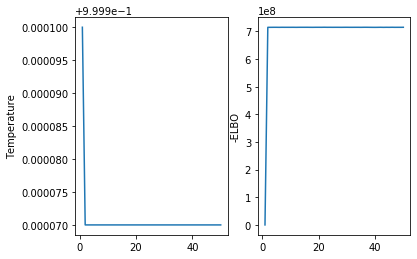

In [60]:
dat=np.array(dat).T
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('-ELBO')

In [57]:
dat

[[1, 1.0, 0],
 [2, 0.9999700004499955, 714382446.0],
 [3, 0.9999700004499955, 714302881.25]]